# Survivor Data Modeling

### Import Dependencies

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.exceptions import DataConversionWarning
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import sys
import warnings
import math
import os
import random

warnings.filterwarnings("ignore", category=DataConversionWarning)

# Get the current working directory
current_dir = os.getcwd()

# Get the path to the survivorData directory
data_dir = os.path.join(current_dir, '..', 'survivorData2')

### Read in csv files as Dataframes

In [ ]:
# List of CSV file names
csv_files = [
    'advantage_movement.csv',
    'boot_mapping.csv',
    'castaways.csv',
    'castaway_details.csv',
    'challenge_description.csv',
    'challenge_results.csv',
    'confessionals.csv',
    'jury_votes.csv',
    'screen_time.csv',
    'season_palettes.csv',
    'season_summary.csv',
    'survivor_auction.csv',
    'tribe_colours.csv',
    'tribe_mapping.csv',
    'viewers.csv',
    'vote_history.csv'
]

# Create a dictionary to store the DataFrames
dataframes = {}

# Loop through each CSV file and read its data into a DataFrame
for csv_file in csv_files:
    # Specify the relative path to the CSV file
    file_path = os.path.join(data_dir, csv_file)
    
    # Read the data from the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Store the DataFrame in the dictionary
    dataframes[csv_file] = df

# Clean up the data and feature engineering

The final dataset used after initial feature engineering contains 30 columns. The castaways.csv and castaway_details.csv files were merged to create the main dataframe used. As part of the feature engineering process, the "result" column was converted to a categorical variable. In addition, a new "genderNumber" column was created with encoded values 3, 2, 1, 0 representing Male, Female, Non-Binary, and Other categories from the "gender" column. Similarly, a new "won" column was created from the "result" column with encoded values 1 and 0 representing if a contestant was the Sole Survivor (1) or not (0). From the challenge_results.csv file, the total number of immunity wins per contestant were counted and a new column "immunityWins" was added to the dataframe castawayAll. Finally, the dataframe was split into a separate list of dataframes by season.

In [ ]:
# Convert tribe_status column to category type
dataframes['tribe_colours.csv']['tribe_status'] = dataframes['tribe_colours.csv']['tribe_status'].astype('category')

# Convert result to a categorical variable
dataframes['castaways.csv']['result'] = pd.Categorical(dataframes['castaways.csv']['result'])
dataframes['castaways.csv']['result'] = dataframes['castaways.csv']['result'].cat.codes

# Merge challenge_results and castaway_details dataframes on castaway_id
castawayAll = pd.merge(dataframes['castaways.csv'], dataframes['castaway_details.csv'], on='castaway_id', how ="left")

castawayAll['genderNumber'] = np.where(castawayAll['gender'] == 'Male', 1,
                                     np.where(castawayAll['gender'] == 'Female', 2,
                                              np.where(castawayAll['gender'] == 'Non-binary', 3, 0)))
castawayAll['won'] = np.where(castawayAll['result'] == 'Sole Survivor', 1, 0)

castawayAll = castawayAll.dropna(subset=['age'])

### Feature engineering for challenge results data

In [ ]:
# Read the challenge_results.csv file
challenge_results = dataframes['challenge_results.csv']

# Filter out the rows where challenge_type is "Immunity" and the result is "Won"
immunity_wins = challenge_results[(challenge_results['challenge_type'] == 'Immunity') & (challenge_results['result'] == 'Won')]

# Group by 'castaway_id' and count the number of immunity wins
immunity_counts = immunity_wins.groupby('castaway_id').size()

# Convert Series to DataFrame
immunity_counts_df = immunity_counts.reset_index(name='immunityWins')

# Set 'castaway_id' as the index for easier merging later
immunity_counts_df.set_index('castaway_id', inplace=True)

# Set 'castaway_id' as the index for 'castawayAll' dataframe for easier merging
castawayAll.set_index('castaway_id', inplace=True)

# Merge 'immunity_counts_df' into 'castawayAll'
castawayAll = castawayAll.merge(immunity_counts_df, how='left', left_index=True, right_index=True)

# Fill NaN values with 0 - assuming that contestants who didn't win any immunity challenges are not present in the immunity_counts_df DataFrame
castawayAll['immunityWins'].fillna(0, inplace=True)

# # Print out the column names
# print("Columns in the DataFrame:")
# print(castawayAll.columns)

# # Print out how many people got each number of immunity wins
# print("\nNumber of immunity wins for contestants:")
# print(castawayAll['immunityWins'].value_counts())

# # Print out details about the top 10 castaways with the most immunity wins
# top_immunity_winners = castawayAll.nlargest(10, 'immunityWins')
# print("\nTop 10 contestants with the most immunity wins:")
# print(top_immunity_winners[['full_name_x', 'age', 'city', 'state', 'immunityWins']])

# Once implemented, we can add this data to the x_train but x_test will have to be updated between each guess
# # When creating your training and testing datasets, you should now include 'immunityWins' as a feature
# x_train = pd.concat([season_split[i][['age', 'genderNumber', 'immunityWins']] for i in train_index])
# x_test = pd.concat([season_split[i][['age', 'genderNumber', 'immunityWins']] for i in test_index])


### Create a dataframe for each season of the show

In [ ]:
# Split dataframe into a list of dataframes grouped by column name
def split_dataframe(df, column_name):
    groups = df.groupby(column_name)
    result = [group for _, group in groups]
    return result

# Call split_dataframe on column name "version_season"
season_split = split_dataframe(castawayAll, 'version_season')

# Give each contestant which order they were eliminated from the show
for df in season_split:
    df['orderOut'] = range(1, len(df) + 1)

# Using Random Forest Classifier for predicting order out at the start of the show 

In [ ]:
def predict_elimination_order(df):
    # Prepare the data
    features = df[['age', 'genderNumber']]
    target = df['orderOut']

    # Initialize the model
    #model = RandomForestRegressor()
    model = RandomForestClassifier()
    
    # Train the model
    model.fit(features, target)

    # Make predictions
    predictions = model.predict(features)

    # Calculate the root mean square error (RMSE)
    rmse = mean_squared_error(target, predictions, squared=False)

    # print(f"Root Mean Square Error: {rmse}")
    
    # Return the order of elimination predictions
    return predictions
for i, df in enumerate(season_split):
    # print(f"Predicting for season {i+1}")
    predicted_order = predict_elimination_order(df)
    # print(predicted_order)
    

#  Using KNN,Random Forest, and SVM Classification Models for predicting order out at the start of the show 


### Comparison of SVM and Logistic Regression Models:
To determine the best approach for predicting the order of elimination of contestants for each season, we have chosen to compare the performance of three popularclassification machine learning algorithms: k-nearest neigbors (KNN),  Support Vector Machine (SVM) and Random Forest. These models are widely used in classification tasks and have demonstrated success in various domains.

1. k-nearest neighbors (KNN): KNN is a non-parametric, supervised learning classifier, which uses proximity to make classifications or predictions about the grouping of an individual data point.

2. Support Vector Machine (SVM): SVM is a powerful algorithm that aims to find an optimal hyperplane in a high-dimensional feature space. It separates data points into distinct classes by maximizing the margin between them. SVM is known for its ability to handle complex datasets and nonlinear relationships effectively. Its versatility and robustness make it a suitable candidate for predicting color values in a dataset.

3. Random Forest: Random Forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction. 

### Quanitfying Results 

Leave-one-out cross-validation (LOOCV) was used to estimate the performance of our models by training and evaluating it on different subsets of the data testing for accuracy. After training the model, it is evaluated using the left-out sample which measures how well the model generalizes the unseen data. For each iteration, the accuracy was recorded and at the end aggregated to get an overall estimate of the model's performance and compare it with the other models. 

### Model Performance 

In all, none of the models performed very well with low accuracies on the predicted order of elimination.  Overall, the KNN Classification model seemed to perform the best with the k = 7 model having the best accuracy overall of 0.3125 and an average accuracy of 0.067 across seasons. 


## KNN Classification Results for k values from 1 to 10

Based on these results, the most optimal k values for our model that received the highest accuracy scores are k = 2, 4,and 7. 

In [ ]:
#Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

#Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

# Initialize the list to store all the best k-values and best accuracies
all_best_k_values = []
all_best_accuracies = []

# Loop goes through k values from 1 to 10
for train_index, test_index in logo.split(season_split, groups=group_labels):

    X_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    Y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    X_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    Y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])

    # Find the best k value
    best_k = None
    best_accuracy = 0.0

    for k in range(1, 11):  # Try different values of k from 1 to 10
        # Initialize the model
        model = KNeighborsClassifier(n_neighbors=k)

        # Train the model
        model.fit(X_train, Y_train)

        # Make predictions on the test set
        predictions = model.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(Y_test, predictions)

        # Update the best k value if the current accuracy is higher
        if accuracy > best_accuracy:
            best_k = k
            best_accuracy = accuracy

    # Append the best k value and best accuracy to the respective lists
    all_best_k_values.append(best_k)
    all_best_accuracies.append(best_accuracy)

    # print(f"Best k value: {best_k}")
    # print(f"Best accuracy: {best_accuracy}")


In [ ]:
# Sort the accuracies in descending order and get the indices of the top 5 accuracies
top_indices = sorted(range(len(all_best_accuracies)), key=lambda i: all_best_accuracies[i], reverse=True)[:5]

# Get the top 5 k-values and their corresponding accuracies
top_k_values = [all_best_k_values[i] for i in top_indices]
top_accuracies = [all_best_accuracies[i] for i in top_indices]

# Print the top 5 k-values and their accuracies
print("Top 5 k-values:", top_k_values)
print("Top 5 accuracies:", top_accuracies)

Top 5 k-values: [7, 4, 2, 7, 2]
Top 5 accuracies: [0.3125, 0.2777777777777778, 0.25, 0.2222222222222222, 0.20833333333333334]


## KNN,Random Forest, and SVM Classification Models

In [ ]:
#Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

#Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

accuracies_knn2 = []  # Create an empty list to store accuracies
accuracies_knn4 = []  # Create an empty list to store accuracies
accuracies_knn7 = []  # Create an empty list to store accuracies
accuracies_RF   = []  # Create an empty list to store accuracies
accuracies_SVM   = []  # Create an empty list to store accuracies


i=1
for train_index, test_index in logo.split(season_split, groups=group_labels):

    x_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    x_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])
    
    # Initialize the model
    model = KNeighborsClassifier(n_neighbors=2)
    model2 = KNeighborsClassifier(n_neighbors=4)
    model3 = KNeighborsClassifier(n_neighbors=7)
    model4 = RandomForestClassifier()
    model5 = svm.SVC()

    #Train the model
    model.fit(x_train, y_train)
    model2.fit(x_train, y_train)
    model3.fit(x_train, y_train)
    model4.fit(x_train,y_train)
    model5.fit(x_train,y_train)

    # Make predictions
    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    predictions2 = model2.predict(x_test)
    accuracy2 = accuracy_score(y_test, predictions2)
    predictions3 = model3.predict(x_test)
    accuracy3 = accuracy_score(y_test, predictions3)
    predictions4 = model4.predict(x_test)
    accuracy4 = accuracy_score(y_test, predictions4)
    predictions5 = model5.predict(x_test)
    accuracy5 = accuracy_score(y_test, predictions5)
    
    # print("Predictions for Season ", i,"using k=2")
    # print(predictions)
    # print("Accuracy: ",accuracy)
 
    # print("Predictions for Season ", i,"using k=4")
    # print(predictions2)
    # print("Accuracy: ",accuracy2)

    # print("Predictions for Season ", i,"using k=7")
    # print(predictions3)
    # print("Accuracy: ",accuracy3)

    # print("Predictions for Season ", i,"using RandomForest")
    # print(predictions4)
    # print("Accuracy: ",accuracy4)
    
    # print("Predictions for Season ", i,"using SVM")
    # print(predictions5)
    # print("Accuracy: ",accuracy5)

    #Append the accuracy to the list accuracies_knn
    accuracies_knn2.append(accuracy)
    accuracies_knn4.append(accuracy2)
    accuracies_knn7.append(accuracy3)
    accuracies_RF.append(accuracy4)
    accuracies_SVM.append(accuracy5)
    
    
    i+=1


In [ ]:
# Create a dictionary to store the lists
lists = {
    "accuracies_knn2": accuracies_knn2,
    "accuracies_knn4": accuracies_knn4,
    "accuracies_knn7": accuracies_knn7,
    "accuracies_RF": accuracies_RF,
    "accuracies_SVM": accuracies_SVM
}

# Iterate over each list
for list_name, accuracy_list in lists.items():
    # Find the top 5 accuracies
    top_5 = sorted(accuracy_list, reverse=True)[:5]
    # Calculate the average accuracy
    average_accuracy = sum(accuracy_list) / len(accuracy_list)
    
    # Print the results
    # print(f"Top 5 accuracies for {list_name}: {top_5}")
    # print(f"Average accuracy for {list_name}: {average_accuracy}\n")

### Model Analysis

Overall the Knn models performed the better than random forest and svm. The support vector machine model has a significant bimodal distribution of accuracies which we are unable to explain.

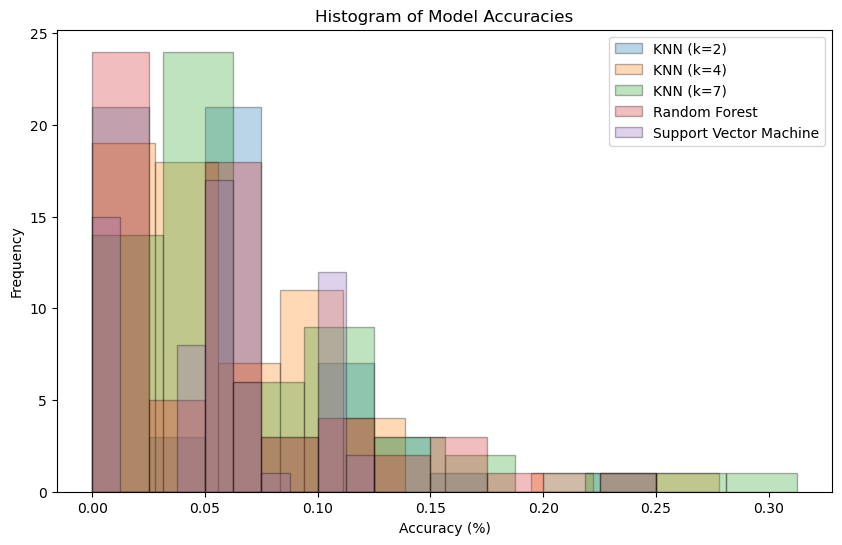

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot histogram for KNN models
plt.hist(accuracies_knn2, bins=10, edgecolor='black', alpha=0.3, label='KNN (k=2)')
plt.hist(accuracies_knn4, bins=10, edgecolor='black', alpha=0.3, label='KNN (k=4)')
plt.hist(accuracies_knn7, bins=10, edgecolor='black', alpha=0.3, label='KNN (k=7)')

# Plot histogram for Random Forest model
plt.hist(accuracies_RF, bins=10, edgecolor='black', alpha=0.3, label='Random Forest')

# Plot histogram for Support Vector Machine model
plt.hist(accuracies_SVM, bins=10, edgecolor='black', alpha=0.3, label='Support Vector Machine')

# Set title and labels
plt.title('Histogram of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


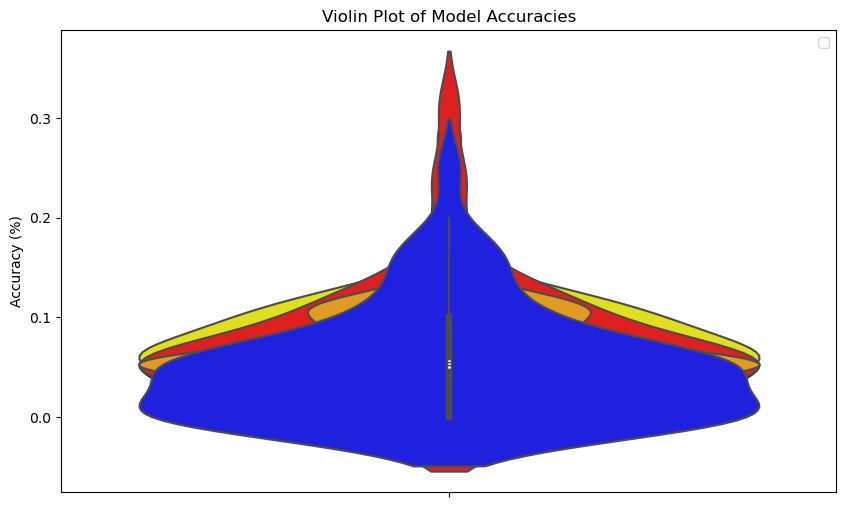

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot violin plot for KNN models
sns.violinplot(y=accuracies_knn2, color='green', label='KNN (k=1)')
sns.violinplot(y=accuracies_knn4, color='yellow', label='KNN (k=3)')
sns.violinplot(y=accuracies_knn7, color='red', label='KNN (k=7)')

# Plot violin plot for Support Vector Machine model
sns.violinplot(y=accuracies_SVM, color='orange', label='Support Vector Machine')

# Plot violin plot for Random Forest model
sns.violinplot(y=accuracies_RF, color='blue', label='Random Forest')

# Set title and labels
plt.title('Violin Plot of Model Accuracies')
plt.ylabel('Accuracy (%)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

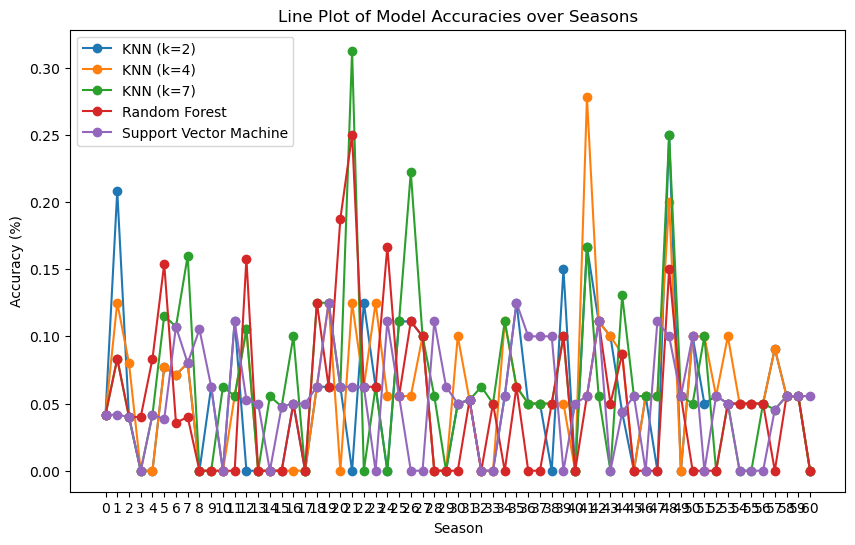

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot accuracies for KNN models
ax.plot(range(1, len(accuracies_knn2) + 1), accuracies_knn2, marker='o', label='KNN (k=2)')
ax.plot(range(1, len(accuracies_knn4) + 1), accuracies_knn4, marker='o', label='KNN (k=4)')
ax.plot(range(1, len(accuracies_knn7) + 1), accuracies_knn7, marker='o', label='KNN (k=7)')


# Plot accuracies for Random Forest model
ax.plot(range(1, len(accuracies_RF) + 1), accuracies_RF, marker='o', label='Random Forest')

# Plot accuracies for Support Vector Machine model
ax.plot(range(1, len(accuracies_SVM) + 1), accuracies_SVM, marker='o', label='Support Vector Machine')

# Set title and labels
ax.set_title('Line Plot of Model Accuracies over Seasons')
ax.set_xlabel('Season')
ax.set_ylabel('Accuracy (%)')

# Set the x-axis ticks and labels
ax.set_xticks(range(1, len(accuracies_RF) + 1))
ax.set_xticklabels(group_labels)

# Add a legend
ax.legend()

# Show the plot
plt.show()

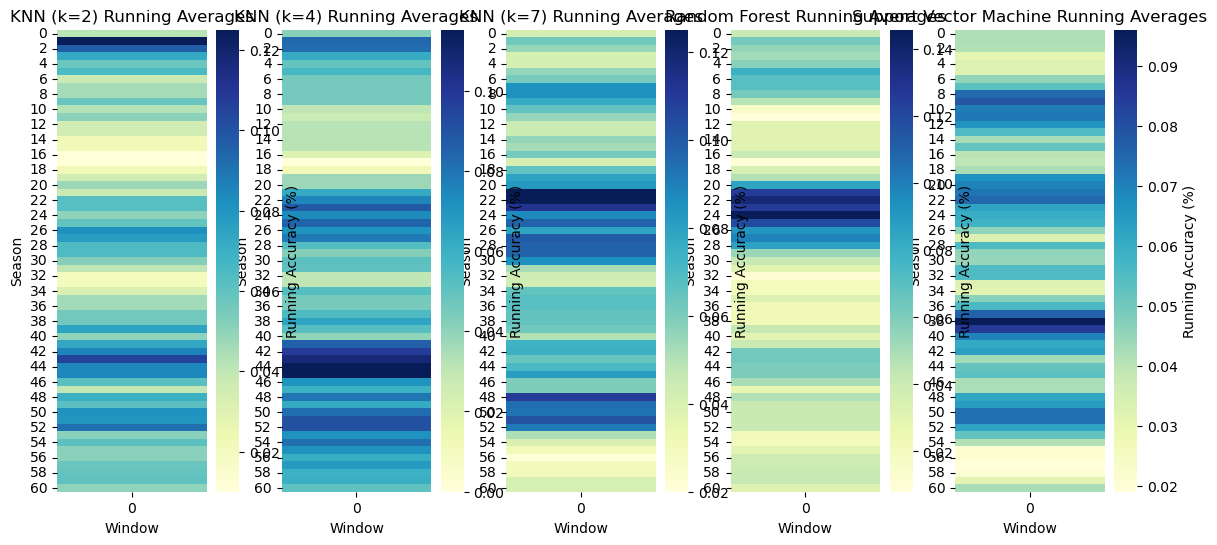

In [ ]:
# Compute running averages over a window of 5 seasons
window_size = 5
running_averages_knn2 = [np.mean(accuracies_knn2[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_knn2))]
running_averages_knn4 = [np.mean(accuracies_knn4[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_knn4))]
running_averages_knn7 = [np.mean(accuracies_knn7[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_knn7))]

running_averages_rf = [np.mean(accuracies_RF[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_RF))]
running_averages_svm = [np.mean(accuracies_SVM[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_SVM))]

# Create 2D arrays for the heatmaps
heatmap_data_knn2 = np.array(running_averages_knn2).reshape(-1, 1)
heatmap_data_knn4 = np.array(running_averages_knn4).reshape(-1, 1)
heatmap_data_knn7 = np.array(running_averages_knn7).reshape(-1, 1)

heatmap_data_rf = np.array(running_averages_rf).reshape(-1, 1)
heatmap_data_svm = np.array(running_averages_svm).reshape(-1, 1)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(ncols=5, figsize=(14, 6))

# Plot the heatmaps in their respective subplots
sns.heatmap(heatmap_data_knn2, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[0])
sns.heatmap(heatmap_data_knn4, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[1])
sns.heatmap(heatmap_data_knn7, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[2])

sns.heatmap(heatmap_data_rf, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[3])
sns.heatmap(heatmap_data_svm, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[4])

# Set the titles of the subplots
axs[0].set_title('KNN (k=2) Running Averages')
axs[1].set_title('KNN (k=4) Running Averages')
axs[2].set_title('KNN (k=7) Running Averages')

axs[3].set_title('Random Forest Running Averages')
axs[4].set_title('Support Vector Machine Running Averages')

# Set the labels of the subplots
for ax in axs:
    ax.set_xlabel('Window')
    ax.set_ylabel('Season')

plt.show()

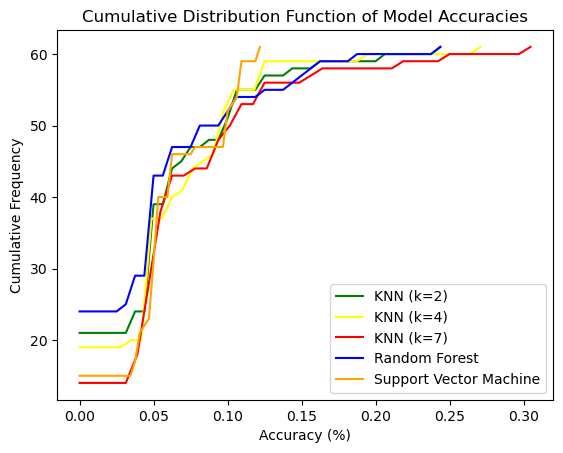

In [ ]:
# Compute CDF for KNN accuracies
values_knn2, base_knn2 = np.histogram(accuracies_knn2, bins=40)
cumulative_knn2 = np.cumsum(values_knn2)

values_knn4, base_knn4 = np.histogram(accuracies_knn4, bins=40)
cumulative_knn4 = np.cumsum(values_knn4)

values_knn7, base_knn7 = np.histogram(accuracies_knn7, bins=40)
cumulative_knn7 = np.cumsum(values_knn7)

# Compute CDF for Random Forest accuracies
values_rf, base_rf = np.histogram(accuracies_RF, bins=40)
cumulative_rf = np.cumsum(values_rf)

# Compute CDF for Support Vector Machine accuracies
values_svm, base_svm = np.histogram(accuracies_SVM, bins=40)
cumulative_svm = np.cumsum(values_svm)

plt.plot(base_knn2[:-1], cumulative_knn2, c='green', label='KNN (k=2)')
plt.plot(base_knn4[:-1], cumulative_knn4, c='yellow', label='KNN (k=4)')
plt.plot(base_knn7[:-1], cumulative_knn7, c='red', label='KNN (k=7)')
plt.plot(base_rf[:-1], cumulative_rf, c='blue', label='Random Forest')
plt.plot(base_svm[:-1], cumulative_svm, c='orange', label='Support Vector Machine')

plt.title('Cumulative Distribution Function of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Cumulative Frequency')
plt.legend() # To distinguish between different lines in the plot
plt.show()

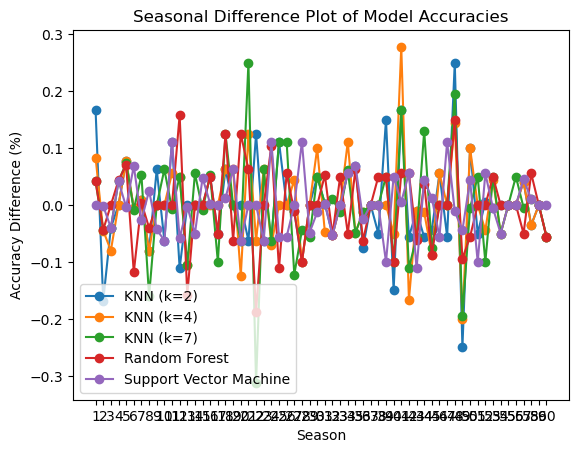

In [ ]:
# Compute differences for KNN accuracies
differences_knn2 = [j - i for i, j in zip(accuracies_knn2[:-1], accuracies_knn2[1:])]
differences_knn4 = [j - i for i, j in zip(accuracies_knn4[:-1], accuracies_knn4[1:])]
differences_knn7 = [j - i for i, j in zip(accuracies_knn7[:-1], accuracies_knn7[1:])]

# Compute differences for Random Forest accuracies
differences_rf = [j - i for i, j in zip(accuracies_RF[:-1], accuracies_RF[1:])]

# Compute differences for Support Vector Machine accuracies
differences_svm = [j - i for i, j in zip(accuracies_SVM[:-1], accuracies_SVM[1:])]

plt.plot(range(1, len(differences_knn2) + 1), differences_knn2, marker='o', label='KNN (k=2)')
plt.plot(range(1, len(differences_knn4) + 1), differences_knn4, marker='o', label='KNN (k=4)')
plt.plot(range(1, len(differences_knn7) + 1), differences_knn7, marker='o', label='KNN (k=7)')
plt.plot(range(1, len(differences_rf) + 1), differences_rf, marker='o', label='Random Forest')
plt.plot(range(1, len(differences_svm) + 1), differences_svm, marker='o', label='Support Vector Machine')

plt.title('Seasonal Difference Plot of Model Accuracies')
plt.xlabel('Season')
plt.ylabel('Accuracy Difference (%)')
plt.xticks(ticks=range(1, len(differences_rf) + 1), labels=group_labels[1:])
plt.legend()  # To distinguish between different lines in the plot
plt.show()

# Simulation of survivor seasons and predicting the order in which people leave the game

The simulation model employed in this code is well-suited for the given dataset, which corresponds to the TV show Survivor. In Survivor, contestants are eliminated one by one, and an obvious objective is to predict the next person who will leave the show. To ensure accurate predictions, it is crucial to consider only the remaining contestants at each stage, as those who have already been eliminated would not contribute to the decision-making process.

The code implements a leave-one-group-out cross-validation technique, which aligns with the Survivor format. Each iteration of the cross-validation loop represents a new stage of the show, where a group of contestants is considered for prediction while excluding the others who have already been eliminated. This simulation approach ensures that the predictions are based on the available pool of contestants, mimicking the progression of the actual show.

By training and evaluating the SVM and logistic regression models on the remaining contestants in each iteration, the simulation model captures the dynamic nature of Survivor, where the characteristics and interactions among the remaining contestants influence the prediction outcomes. The model predicts the "orderOut" values (the order of elimination) for the test set, and the accuracy of the predicted outcomes is calculated against the true outcomes.

Overall, this simulation model ideologically aligns with Survivor by accounting for the evolving dynamics of the show, focusing on the remaining contestants, and predicting their order of elimination. It ensures that predictions are based on the relevant subset of contestants and provides a practical and effective approach for forecasting the outcomes in the context of the TV show Survivor.

### Status of capabilities

The provided code is still a work in progress and requires further refinement to ensure accurate incorporation of the concept of considering only the remaining contestants at each stage. Adjustments and modifications are needed to improve the code's adherence to the elimination rules of the Survivor show.

Additionally, fine-tuning the model's parameters and implementing appropriate data preprocessing techniques are essential steps to enhance the accuracy of the predictions. While progress has been made in filtering out eliminated contestants from the prediction process, further testing and evaluation are necessary to ensure the logic is robust and reliable.

Another important aspect that requires attention is the handling of missing or incomplete data. Devising effective strategies to address missing values and ensuring the completeness of the dataset will contribute to more accurate predictions.

Ongoing development and iterative improvements are crucial to align the simulation model more closely with the actual progression of the Survivor TV show. Through these efforts, meaningful insights can be provided, enabling better predictions of the order of elimination

In [ ]:
# Use a random forest model that tries to predict the order the remaining contestants will be eliminated from the show.
#       Return the contestant remaining that has the lowest orderOut prediction
#       An orderOut value of 1 means that person was the first eleminated and the hightest orderOut in that season is the winner
#       x_train is the age and gender of contestants in the training set
#       y_train is the orderOut for contestants in the training set
#       current_order is the orderOut value that is being predicted
def person_prediction_random_forest(remaining_contestants, x_train_current, y_train_current, current_order):
    # Train the random forest model
    model = RandomForestClassifier()
    model.fit(x_train_current, y_train_current)

    # Predict the order for the remaining contestants
    x_test_current = remaining_contestants[['age', 'genderNumber']]
    predicted_order = model.predict(x_test_current)

    # Find the contestants with the smallest predicted order
    min_predicted_order = np.min(predicted_order)
    contestants_with_min_order = np.where(predicted_order == min_predicted_order)[0]

    # Randomly select one contestant from those with the smallest predicted order
    person_predicted = np.random.choice(contestants_with_min_order)

    return person_predicted

def person_prediction_support_vector_machine(remaining_contestants, x_train_current, y_train_current, current_order):
    # Train the support vector machien model using a "one-vs-rest" decision function shape
    model = svm.SVC(decision_function_shape='ovo')
    model.fit(x_train_current, y_train_current)

    # Predict the order for the remaining contestants
    x_test_current = remaining_contestants[['age', 'genderNumber']]
    predicted_order = model.predict(x_test_current)

    # Find the contestants with the smallest predicted order
    min_predicted_order = np.min(predicted_order)
    contestants_with_min_order = np.where(predicted_order == min_predicted_order)[0]

    # Randomly select one contestant from those with the smallest predicted order
    person_predicted = np.random.choice(contestants_with_min_order)

    return person_predicted

# NOT WORKING
# This is run after each person is eliminated 
def generate_challenge_features(challenge_results, current_season, current_episode):
    # Filter the rows for the current season and episode
    # current_results = challenge_results[(challenge_results['season'] == current_season) & (challenge_results['episode'] == current_episode)]
    
    # # Generate recent_challenge_result
    # current_results['recent_challenge_result'] = current_results['result'].map({'Won': 1, 'Lost': 0})
    
    # # Generate total_wins_so_far
    # total_wins = challenge_results[(challenge_results['season'] == current_season) & (challenge_results['episode'] <= current_episode) & (challenge_results['result'] == 'Won')].groupby('castaway_id').size()
    # total_wins_df = total_wins.reset_index(name='total_wins_so_far')
    
    # # Merge recent_challenge_result and total_wins_so_far into current_results
    # current_results = current_results.merge(total_wins_df, how='left', on='castaway_id')
    # current_results['total_wins_so_far'].fillna(0, inplace=True)
    
    # return current_results[['castaway_id', 'recent_challenge_result', 'total_wins_so_far']]
    return challenge_results

In [ ]:
# Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

# Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

# print(len(season_split))
# print(len(group_labels))

accuracies_random_forest = []  # Create an empty list to store accuracies

for train_index, test_index in logo.split(season_split, groups=group_labels):

    x_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    x_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])

    number_of_contestants = len(x_test)
    order_out = 1
    correct_predictions = 0

    while len(x_test) > 0:
        age_eliminated = x_test.iloc[0]['age']
        gender_number_eliminated = x_test.iloc[0]['genderNumber']
        
        # Select a person
        prediction_person_index = person_prediction_random_forest(x_test, x_train, y_train, order_out)
        
        # print("-------------------------------------")
        # print(f"Person prediction position: {prediction_person_index}")
        # print(f"Person prediction age: {x_test.iloc[prediction_person_index]['age']}")
        
        # print(f"Person eleminated position: {prediction_person_index}")
        # print(f"Person eleminated age: {age_eliminated}")
        # print("-------------------------------------")
        
        # Check if the prediction is correct
        if prediction_person_index == 0:
            correct_predictions += 1
        
        # Remove the first element of x_test
        x_test = x_test.iloc[1:]
        order_out = order_out + 1
        
        current_season = 0
        current_episode = 0
        
        # Update x_test to include updated challenge results
        challenge_features = generate_challenge_features(x_test, current_season, current_episode)
        # x_test = x_test.merge(challenge_features, how='left', on='castaway_id')

    # Calculate and print the accuracy of the model
    # print("----------")
    # print(number_of_contestants)
    accuracy = (correct_predictions / number_of_contestants) * 100
    accuracies_random_forest.append(accuracy)
    # print(f"Model Accuracy: {accuracy}%")
    # print("----------")
    
# print(x_test)
# print(y_test)
print(accuracies_random_forest)

[20.833333333333336, 16.666666666666664, 12.0, 16.0, 25.0, 3.8461538461538463, 14.285714285714285, 12.0, 10.526315789473683, 12.5, 25.0, 5.555555555555555, 31.57894736842105, 20.0, 22.22222222222222, 19.047619047619047, 5.0, 25.0, 12.5, 18.75, 18.75, 25.0, 12.5, 18.75, 16.666666666666664, 16.666666666666664, 27.77777777777778, 15.0, 16.666666666666664, 12.5, 10.0, 10.526315789473683, 12.5, 20.0, 22.22222222222222, 18.75, 20.0, 15.0, 20.0, 10.0, 20.0, 27.77777777777778, 16.666666666666664, 15.0, 13.043478260869565, 16.666666666666664, 11.11111111111111, 22.22222222222222, 20.0, 27.77777777777778, 10.0, 20.0, 22.22222222222222, 15.0, 35.0, 15.0, 15.0, 9.090909090909092, 22.22222222222222, 11.11111111111111, 11.11111111111111]


In [ ]:
# Perform leave-one-group-out cross-validation
logo = LeaveOneGroupOut()

# Create a list of group labels corresponding to each DataFrame in season_split
group_labels = [i for i, _ in enumerate(season_split)]

# print(len(season_split))
# print(len(group_labels))

accuracies_support_vector_machine = []  # Create an empty list to store accuracies

for train_index, test_index in logo.split(season_split, groups=group_labels):

    x_train = pd.concat([season_split[i][['age', 'genderNumber']] for i in train_index])
    y_train = pd.concat([season_split[i][['orderOut']] for i in train_index])

    x_test = pd.concat([season_split[i][['age', 'genderNumber']] for i in test_index])
    y_test = pd.concat([season_split[i][['orderOut']] for i in test_index])

    number_of_contestants = len(x_test)
    order_out = 1
    correct_predictions = 0

    while len(x_test) > 0:
        age_eliminated = x_test.iloc[0]['age']
        gender_number_eliminated = x_test.iloc[0]['genderNumber']
        
        # Select a person
        prediction_person_index = person_prediction_support_vector_machine(x_test, x_train, y_train, order_out)
        
        # print("-------------------------------------")
        # print(f"Person prediction position: {prediction_person_index}")
        # print(f"Person prediction age: {x_test.iloc[prediction_person_index]['age']}")
        
        # print(f"Person eleminated position: {prediction_person_index}")
        # print(f"Person eleminated age: {age_eliminated}")
        # print("-------------------------------------")
        
        # Check if the prediction is correct
        if prediction_person_index == 0:
            correct_predictions += 1
        
        # Remove the first element of x_test
        x_test = x_test.iloc[1:]
        order_out = order_out + 1
        
        current_season = 0
        current_episode = 0
        
        # Update x_test to include updated challenge results
        challenge_features = generate_challenge_features(x_test, current_season, current_episode)
        # x_test = x_test.merge(challenge_features, how='left', on='castaway_id')

    # Calculate and print the accuracy of the model
    # print("----------")
    # print(number_of_contestants)
    accuracy = (correct_predictions / number_of_contestants) * 100
    accuracies_support_vector_machine.append(accuracy)
    # print(f"Model Accuracy: {accuracy}%")
    # print("----------")
    
# print(x_test)
# print(y_test)
print(accuracies_support_vector_machine)

[12.5, 25.0, 16.0, 16.0, 12.5, 23.076923076923077, 10.714285714285714, 4.0, 26.31578947368421, 37.5, 12.5, 11.11111111111111, 31.57894736842105, 20.0, 5.555555555555555, 19.047619047619047, 25.0, 30.0, 6.25, 12.5, 18.75, 25.0, 31.25, 31.25, 11.11111111111111, 16.666666666666664, 16.666666666666664, 10.0, 22.22222222222222, 25.0, 30.0, 15.789473684210526, 25.0, 10.0, 16.666666666666664, 25.0, 25.0, 20.0, 25.0, 15.0, 20.0, 27.77777777777778, 5.555555555555555, 10.0, 34.78260869565217, 5.555555555555555, 22.22222222222222, 16.666666666666664, 25.0, 27.77777777777778, 30.0, 20.0, 16.666666666666664, 10.0, 15.0, 15.0, 20.0, 27.27272727272727, 22.22222222222222, 16.666666666666664, 16.666666666666664]


### Model analysis

Both models have similar characteristics and results across all visualizations. We expect the season to season swings in prediction power comes down to randomness. The support vector machine seems to slightly outperform the random forest with a 95% confidence interval of (-1.5, 4.2).

In [ ]:
# Compute the differences in accuracies between the two models
diff_accuracies = np.array(accuracies_support_vector_machine) - np.array(accuracies_random_forest)

# Perform paired t-test
t_statistic, p_value = stats.ttest_1samp(diff_accuracies, 0)

# Compute 95% confidence interval of the mean difference
confidence_interval = stats.t.interval(0.95, len(diff_accuracies)-1, loc=np.mean(diff_accuracies), scale=stats.sem(diff_accuracies))

print(f"t statistic: {t_statistic}")
print(f"p value: {p_value}")
print(f"95% confidence interval: {confidence_interval}")

t statistic: 1.680250483922013
p value: 0.09810844984284965
95% confidence interval: (-0.4176233431369627, 4.802673571530402)


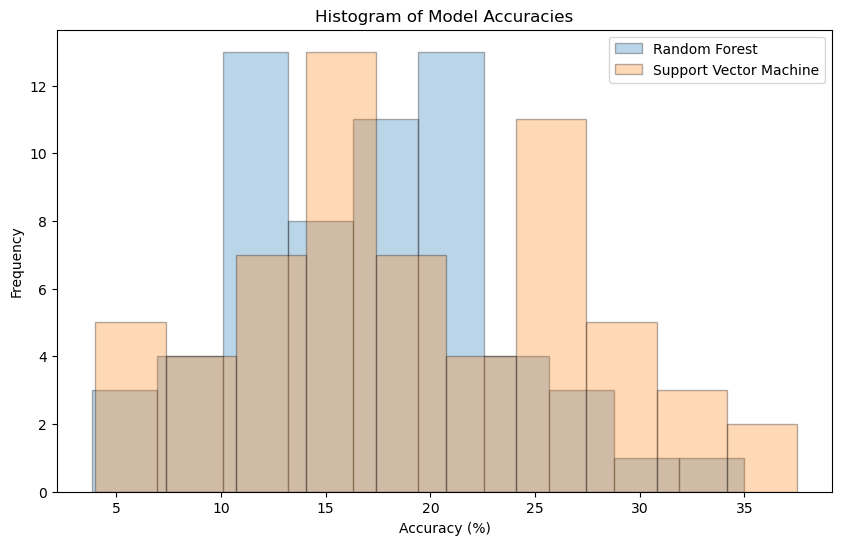

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot histogram for Random Forest model
plt.hist(accuracies_random_forest, bins=10, edgecolor='black', alpha=0.3, label='Random Forest')

# Plot histogram for Support Vector Machine model
plt.hist(accuracies_support_vector_machine, bins=10, edgecolor='black', alpha=0.3, label='Support Vector Machine')

# Set title and labels
plt.title('Histogram of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Frequency')

# Add a legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


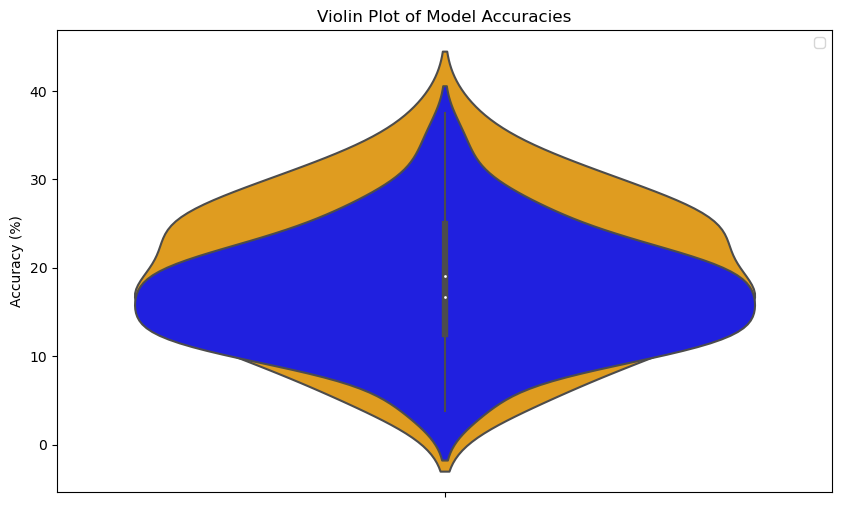

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot violin plot for Support Vector Machine model
sns.violinplot(y=accuracies_support_vector_machine, color='orange', label='Support Vector Machine')

# Plot violin plot for Random Forest model
sns.violinplot(y=accuracies_random_forest, color='blue', label='Random Forest')

# Set title and labels
plt.title('Violin Plot of Model Accuracies')
plt.ylabel('Accuracy (%)')

# Add a legend
plt.legend()

# Show the plot
plt.show()

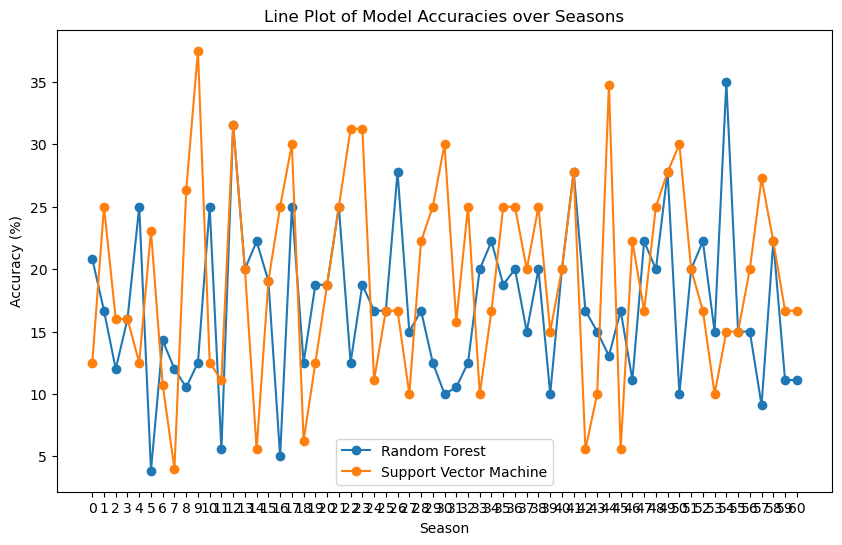

In [ ]:
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Plot accuracies for Random Forest model
ax.plot(range(1, len(accuracies_random_forest) + 1), accuracies_random_forest, marker='o', label='Random Forest')

# Plot accuracies for Support Vector Machine model
ax.plot(range(1, len(accuracies_support_vector_machine) + 1), accuracies_support_vector_machine, marker='o', label='Support Vector Machine')

# Set title and labels
ax.set_title('Line Plot of Model Accuracies over Seasons')
ax.set_xlabel('Season')
ax.set_ylabel('Accuracy (%)')

# Set the x-axis ticks and labels
ax.set_xticks(range(1, len(accuracies_random_forest) + 1))
ax.set_xticklabels(group_labels)

# Add a legend
ax.legend()

# Show the plot
plt.show()

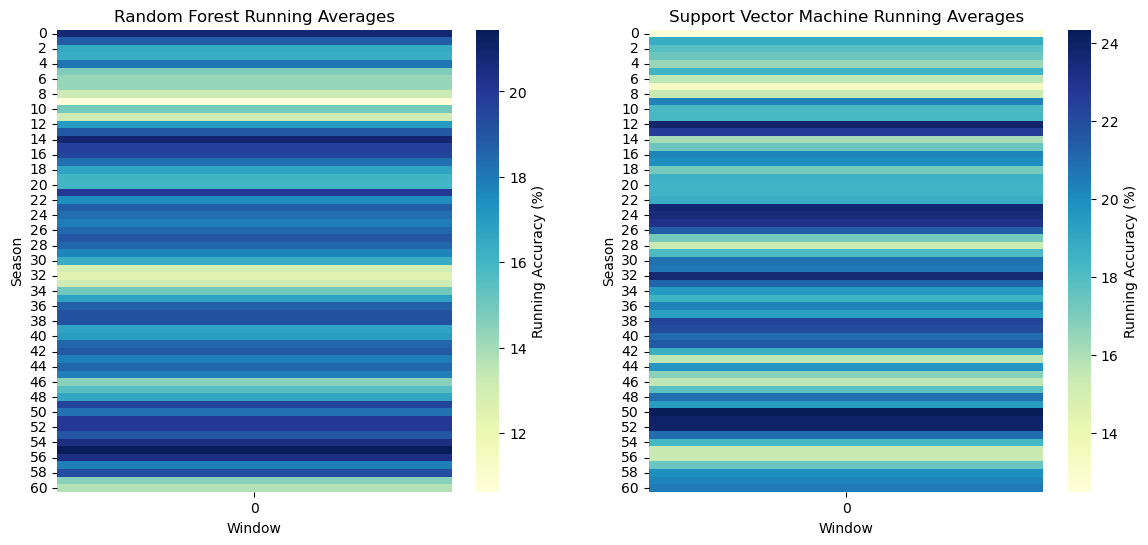

In [ ]:
# Compute running averages over a window of 5 seasons
window_size = 5
running_averages_rf = [np.mean(accuracies_random_forest[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_random_forest))]
running_averages_svm = [np.mean(accuracies_support_vector_machine[max(0, i-window_size+1):i+1]) for i in range(len(accuracies_support_vector_machine))]

# Create 2D arrays for the heatmaps
heatmap_data_rf = np.array(running_averages_rf).reshape(-1, 1)
heatmap_data_svm = np.array(running_averages_svm).reshape(-1, 1)

# Create a figure with two subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(14, 6))

# Plot the heatmaps in their respective subplots
sns.heatmap(heatmap_data_rf, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[0])
sns.heatmap(heatmap_data_svm, cmap="YlGnBu", cbar_kws={'label': 'Running Accuracy (%)'}, ax=axs[1])

# Set the titles of the subplots
axs[0].set_title('Random Forest Running Averages')
axs[1].set_title('Support Vector Machine Running Averages')

# Set the labels of the subplots
for ax in axs:
    ax.set_xlabel('Window')
    ax.set_ylabel('Season')

plt.show()

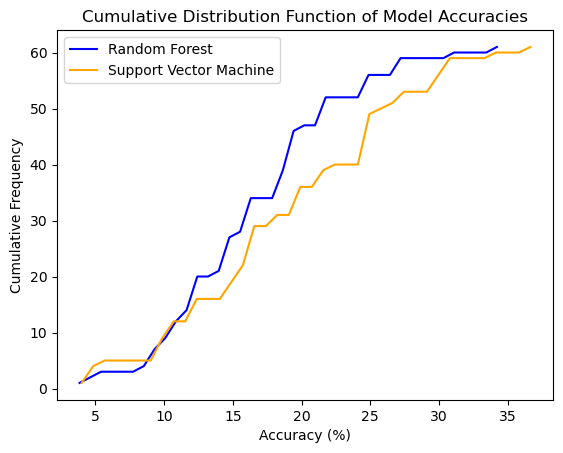

In [ ]:
# Compute CDF for Random Forest accuracies
values_rf, base_rf = np.histogram(accuracies_random_forest, bins=40)
cumulative_rf = np.cumsum(values_rf)

# Compute CDF for Support Vector Machine accuracies
values_svm, base_svm = np.histogram(accuracies_support_vector_machine, bins=40)
cumulative_svm = np.cumsum(values_svm)

plt.plot(base_rf[:-1], cumulative_rf, c='blue', label='Random Forest')
plt.plot(base_svm[:-1], cumulative_svm, c='orange', label='Support Vector Machine')

plt.title('Cumulative Distribution Function of Model Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Cumulative Frequency')
plt.legend() # To distinguish between different lines in the plot
plt.show()

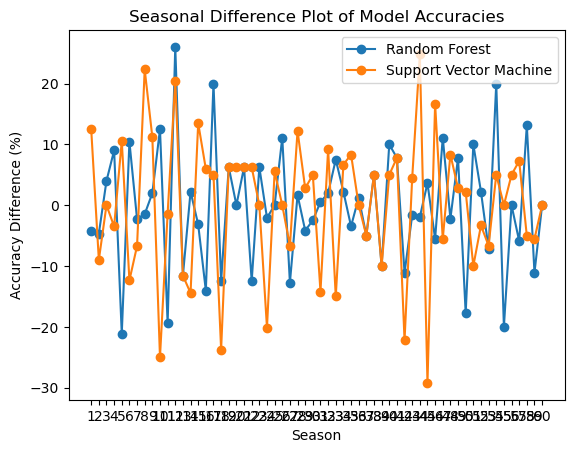

In [ ]:
# Compute differences for Random Forest accuracies
differences_rf = [j - i for i, j in zip(accuracies_random_forest[:-1], accuracies_random_forest[1:])]

# Compute differences for Support Vector Machine accuracies
differences_svm = [j - i for i, j in zip(accuracies_support_vector_machine[:-1], accuracies_support_vector_machine[1:])]

plt.plot(range(1, len(differences_rf) + 1), differences_rf, marker='o', label='Random Forest')
plt.plot(range(1, len(differences_svm) + 1), differences_svm, marker='o', label='Support Vector Machine')

plt.title('Seasonal Difference Plot of Model Accuracies')
plt.xlabel('Season')
plt.ylabel('Accuracy Difference (%)')
plt.xticks(ticks=range(1, len(differences_rf) + 1), labels=group_labels[1:])
plt.legend()  # To distinguish between different lines in the plot
plt.show()

# Usefulness of models

Despite a large amount of attributes and instances, we were limited on useful data, especially when trying to make predictions without up to date challenge results. For instance, information that could have been useful like race and personality type have an overwhelming amount of NA’s. We were left with age and gender for our useful attributes without feature engineering up to date challenge or voting results. 
Survivor comes down to luck and social interaction which are unmeasurable attributes. For example, you can be a great puzzle solver or the strongest contestant, but if you have a big ego or aren't good at cultivating friendships, these are always early ways to get voted out. This is important to note when considering the accuracy of the models we ran. None of the models can account for these core attributes of Survivor but we hope to test and uncover insights with what is available.

The code we have is a great starting point for creating more useful models if better data is collected or feature engineered. The models that predict the order at the start of the show can give insight into what attributes to look out for when watching and predicting someone who won't get voted off first. The models that maintain up to date information before each vote will have more informed predictions. 
At the very least this piece of functionality can output relevant up to date information someone might want to look at before making a decision. There is potential prediction power in data such as challenge and voting results. So despite the expected low accuracy of all of the models they could provide useful information and insights into predictions.

# Goals:

1. Unit/Functional Testing: We are aiming to set up more comprehensive testing to verify that the simulation is working as intended. This will involve designing test cases that cover various scenarios and edge cases to ensure the code handles them correctly.

2. Updating x_test DataFrame: We plan to update the x_test DataFrame with data from previous events of the current season such as challenge results.

3. Create visualization to see if there is a relationship between age and likelyhood of being eliminated from the show due to a medical emergency or any other reason besides a vote. If there is a correlation try to leverage this knowledge in models.